# Figure 6: Rats with lesions of the dorsal striatum display increased sensitivity to movement cost. 

## setup and imports

In [ ]:
import fnmatch
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth
from scipy.optimize import curve_fit

from sessionlists import (dist60, dist90, dist120, TM20, TM10, TM2, TMrev2, TMrev10, TMrev20)
from utils import *
from plotting import *
from model_functions import *
from process_functions import SampleSet

plt.style.use('./Figures/paper.mplstyle')

In [22]:
# Define folder with data
root = "/home/thomas/Desktop/ALLDATA"
histologyroot="/home/thomas/Desktop/HISTOLOGY"

print("Path to data is: %s"%root)
print("Path to histology is: %s"%histologyroot)
print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')
print(f'Found {len(glob.glob(histologyroot+"/*"))} rats in the histology folder')

Path to data is: /home/thomas/Desktop/ALLDATA
Path to histology is: /home/thomas/Desktop/HISTOLOGY
Found 34 rats in the data folder
Found 13 rats in the histology folder


In [23]:
rat_markers = {}
sequence = {}

animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']

intact_rats = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
                    'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 'RatM53', 'RatM54']

lesioned_rats = ['RatF30', 'RatF31', 'RatM30', 'RatF40', 'RatF41', 'RatM41', 'RatM42',
            'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52']


m, f, l = 0, 0, 0
male_palette = create_teal_palette(num_shades=len([x for x in intact_rats if 'M' in x]))
female_palette = create_blue_violet_palette(num_shades=len([x for x in intact_rats if 'F' in x]), start_intensity=80)
palette = create_kiwi_green_palette(num_shades=len(lesioned_rats))
for index, animal in enumerate(intact_rats):
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[female_palette[f], 'o', '-']
        f += 1
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[male_palette[m], 'o', '-']
        m += 1
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")


for index, animal in enumerate(lesioned_rats):
    if fnmatch.fnmatch(animal, 'Rat*'):
        rat_markers[animal]=[palette[l], 'o']
        l += 1
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")



# Load data
effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u, power = pickle.load(open('picklejar/effort_sensitivity_fit.p', 'rb'))
alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']
median_alpha_0 = {animal: np.median([alpha_0[animal][cond] for cond in conds]) for animal in animalList}
median_alpha_t = {animal: np.median([alpha_t[animal][cond] for cond in conds]) for animal in animalList}
median_alpha_u = {animal: np.median([alpha_u[animal][cond] for cond in conds]) for animal in animalList}
median_gamma_0 = {animal: np.median([gamma_0[animal][cond] for cond in conds]) for animal in animalList}
median_gamma_t = {animal: np.median([gamma_t[animal][cond] for cond in conds]) for animal in animalList}
median_gamma_u = {animal: np.median([gamma_u[animal][cond] for cond in conds]) for animal in animalList}
median_mu_0 = {animal: np.median([mu_0[animal][cond] for cond in conds]) for animal in animalList}
median_mu_t = {animal: np.median([mu_t[animal][cond] for cond in conds]) for animal in animalList}
median_mu_u = {animal: np.median([mu_u[animal][cond] for cond in conds]) for animal in animalList}
median_sigma_0 = {animal: np.median([sigma_0[animal][cond] for cond in conds]) for animal in animalList}
median_sigma_t = {animal: np.median([sigma_t[animal][cond] for cond in conds]) for animal in animalList}
median_sigma_u = {animal: np.median([sigma_u[animal][cond] for cond in conds]) for animal in animalList}

vars = [effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u, median_alpha_0, median_alpha_t, median_alpha_u, median_gamma_0, median_gamma_t, median_gamma_u, median_mu_0, median_mu_t, median_mu_u, median_sigma_0, median_sigma_t, median_sigma_u]
names = ['effort_sensitivity_0', 'effort_sensitivity_t', 'effort_sensitivity_u', 'alpha_0', 'alpha_t', 'alpha_u', 'gamma_0', 'gamma_t', 'gamma_u', 'mu_0', 'mu_t', 'mu_u', 'sigma_0', 'sigma_t', 'sigma_u']


# 6A Lesion quantification 

In [24]:

lesion_area = {animal: [] for animal in lesioned_rats}
shifts = {animal: [] for animal in lesioned_rats}
for animal in lesioned_rats:
    animalFolder = histologyroot + '/' + animal

    slices = glob.glob(histologyroot + '/' + animal + '/slice*.csv')
    slices = [slice.split('_')[0] for slice in slices]
    slices = np.unique(slices)

    for slice in slices:
        ROI_Left_Striatum = read_ROI_from_csv(slice + '_Left_Striatum.csv')
        ROI_Right_Striatum = read_ROI_from_csv(slice + '_Right_Striatum.csv')
        ROI_Left_Lesion = read_ROI_from_csv(slice + '_Left_Lesion.csv')
        ROI_Right_Lesion = read_ROI_from_csv(slice + '_Right_Lesion.csv')


        AREA_Left_Striatum = compute_area(ROI_Left_Striatum)
        AREA_Right_Striatum = compute_area(ROI_Right_Striatum)
        AREA_Left_Lesion = compute_area(ROI_Left_Lesion)
        AREA_Right_Lesion = compute_area(ROI_Right_Lesion)

        CENTROID_Left_Striatum, _ = compute_centroid(ROI_Left_Striatum)
        CENTROID_Right_Striatum, _ = compute_centroid(ROI_Right_Striatum)
        CENTROID_Left_Lesion, _ = compute_centroid(ROI_Left_Lesion)
        CENTROID_Right_Lesion, _ = compute_centroid(ROI_Right_Lesion)

        RATIO_Left = AREA_Left_Lesion / AREA_Left_Striatum
        RATIO_Right = AREA_Right_Lesion / AREA_Right_Striatum
        lesion_area[animal].extend((RATIO_Left, RATIO_Right))

        # mediolaterality
        XSHIFT_Left = CENTROID_Left_Lesion - CENTROID_Left_Striatum
        XSHIFT_Right = CENTROID_Right_Lesion - CENTROID_Right_Striatum
        shifts[animal].extend((-XSHIFT_Left, XSHIFT_Right))

lesion_area = {animal: np.mean(lesion_area[animal]) for animal in lesioned_rats}
lesion_pos = {animal: np.mean(shifts[animal]) for animal in lesioned_rats}


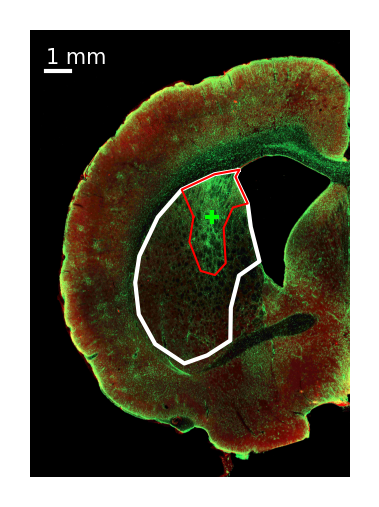

In [43]:
def Figure_6A(ax=None, path=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(1, 1))

    if path is None:
        path = "./Figures/histology.tif"

    img = plt.imread(path)
    ax.imshow(img)

    rat_example_lesion = 'RatF52'
    animalFolder = histologyroot + '/' + rat_example_lesion
    x = read_ROI_from_csv(animalFolder + '/prettyslice_Left_Striatum.csv')[:, 0]
    y = read_ROI_from_csv(animalFolder + '/prettyslice_Left_Striatum.csv')[:, 1]
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    ax.plot(x, y, 'w', lw=1)

    x_lesion = read_ROI_from_csv(animalFolder + '/prettyslice_Left_Lesion.csv')[:, 0]
    y_lesion = read_ROI_from_csv(animalFolder + '/prettyslice_Left_Lesion.csv')[:, 1]
    x_lesion = np.append(x_lesion, x_lesion[0])
    y_lesion = np.append(y_lesion, y_lesion[0])
    ax.plot(x_lesion, y_lesion, 'r', lw=.5)

    cx, cy = compute_centroid(read_ROI_from_csv(animalFolder + '/prettyslice_Left_Lesion.csv'))
    ax.scatter(cx, cy, s=10, marker='+', zorder=10, c='lime')

    ax.set_xlim(250, 5250)
    ax.set_ylim(7000, 0)
    ax.axis("off")

    # annotate scale
    dpi = 300
    obj_zoom = 5
    inch = 2.54
    one_mm = 0.1 * inch * dpi * obj_zoom
    
    ax.plot([500, 500+one_mm], [650, 650], 'w', lw=1)
    ax.text(500, 600, '1 mm', color='w', ha='left', va='bottom', fontsize=5)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(16), cm2inch(4)))

Figure_6A(ax=ax)

In [26]:
# functions to compute median ROI
def compute_median_contour(x, y, stat='Med.'):
    # eps, zmax, lenlim used in outlier detection. Here they are set so they don't exclude any outlier in the median computation. Outlying runs will be//are removed beforehand.
    eps = 0.001
    zmax = np.inf
    lenlim=(-np.inf, np.inf)
    data = list(zip(x, y))

    ss = SampleSet(data)
    # ss.getAvg(zmax, lenlim, eps, stat) # not supposed to do anything but has to be here to work ??????? Therefore, no touchy. 
    X, Y = ss.getAvg(zmax, lenlim, eps, stat)
    return X, Y

def smooth_polygon(x, y, num_points=25):
    t = np.linspace(0, 1, len(x))
    t_new = np.linspace(0, 1, num_points)
    spline_x = interp1d(t, x, kind='cubic')
    spline_y = interp1d(t, y, kind='cubic')
    smoothed_x = spline_x(t_new)
    smoothed_y = spline_y(t_new)
    smoothed_x = np.append(smoothed_x, smoothed_x[0])
    smoothed_y = np.append(smoothed_y, smoothed_y[0])
    return smoothed_x, smoothed_y


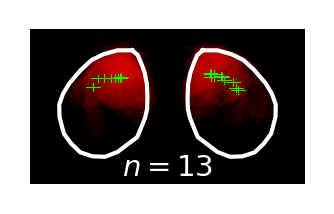

In [27]:
def Figure_6Abis(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(1, 1))

    x_striatum_left, y_striatum_left = [], []
    x_lesion_left, y_lesion_left = [], []
    x_centroid_left, y_centroid_left = [], []
    x_centroid_right, y_centroid_right = [], []
    
    for animal in lesioned_rats:
        # hack because we have the .csv files, but not the .czi files
        animalFolder = histologyroot + '/' + animal
        slicenumber = glob.glob(animalFolder + '/slice*')
        slicenumber = [slice.split('/')[-1] for slice in slicenumber]
        slices = set([animalFolder + '/slice'  + str(''.join(filter(str.isdigit, string))) + '.czi' for string in slicenumber])

        for slice in slices:
            x = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')[:, 0]
            y = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')[:, 1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            y = -y  # flip y axis

            offset_x = np.mean(x) + 1250
            offset_y = np.mean(y)
            x_striatum_left.append(x - offset_x)
            y_striatum_left.append(y - offset_y)

            x_lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')[:, 0]
            y_lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')[:, 1]
            x_lesion = np.append(x_lesion, x_lesion[0])
            y_lesion = np.append(y_lesion, y_lesion[0])
            y_lesion = -y_lesion  # flip y axis

            polygon = Polygon(np.array([x_lesion - offset_x, y_lesion - offset_y]).T, 
                              True, facecolor='r', alpha=.075)
            ax.add_patch(polygon)

            x_lesion_left.append(x_lesion - offset_x)
            y_lesion_left.append(y_lesion - offset_y)


            cx, cy = compute_centroid(read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv'))
            cx -= offset_x
            cy = -cy - offset_y
            x_centroid_left.append(cx)
            y_centroid_left.append(cy)

        _x, _y = (np.median(x_centroid_left), np.median(y_centroid_left))
        s = 150
        ax.plot([_x-s, _x+s], [_y, _y], 'lime', lw=.25)
        s=100
        ax.plot([_x, _x], [_y-s, _y+s], 'lime', lw=.25)

    # x, y = compute_median_contour(x_striatum_left, y_striatum_left, stat='Med.')
    # ax.plot(*smooth_polygon(x, y, num_points=25), 'cyan', lw=1)

    
    x_striatum_right, y_striatum_right = [], []
    x_lesion_right, y_lesion_right = [], []
    x_centroid_right, y_centroid_right = [], []

    for animal in lesioned_rats:
        animalFolder = histologyroot + '/' + animal
        slicenumber = glob.glob(animalFolder + '/slice*')
        slicenumber = [slice.split('/')[-1] for slice in slicenumber]
        slices = set([animalFolder + '/slice'  + str(''.join(filter(str.isdigit, string))) + '.czi' for string in slicenumber])

        for slice in slices:

            x = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')[:, 0]
            y = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')[:, 1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            y = -y  # flip y axis

            offset_x = np.mean(x) - 1250
            offset_y = np.mean(y)
            x_striatum_right.append(x - offset_x)
            y_striatum_right.append(y - offset_y)


            x_lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')[:, 0]
            y_lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')[:, 1]
            x_lesion = np.append(x_lesion, x_lesion[0])
            y_lesion = np.append(y_lesion, y_lesion[0])
            y_lesion = -y_lesion  # flip y axis

            polygon = Polygon(np.array([x_lesion - offset_x, y_lesion - offset_y]).T, 
                              True, facecolor='r', alpha=.075)
            ax.add_patch(polygon)

            x_lesion_right.append(x_lesion - offset_x)
            y_lesion_right.append(y_lesion - offset_y)

            cx, cy = compute_centroid(read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv'))
            cx -= offset_x
            cy = -cy - offset_y
            x_centroid_right.append(cx)
            y_centroid_right.append(cy)
        _x, _y = (np.median(x_centroid_right), np.median(y_centroid_right))
        s = 150
        ax.plot([_x-s, _x+s], [_y, _y], 'lime', lw=.25)
        s=100
        ax.plot([_x, _x], [_y-s, _y+s], 'lime', lw=.25)

    # precomputed median contours
    x_left = [ -769, -1090, -1394, -1655, -1886, -2141, -2278, -2363, -2356, -2260, -2103, -1903, 
        -1633, -1361, -1088 ,  -889, -662,  -580,  -492,  -444 , -438,  -450,  -500 ,  -580, -650,  -769]
    y_left = [ 1300,  1300,  1200,   1050, 800,   449,   180,  -102, -423,  -852, -1105, -1333,
        -1437, -1448, -1322, -1142, -942,  -711,  -451,  -213, 73,   428,   728,   986, 1177,  1300]
    ax.plot(x_left, y_left, 'w', lw=1)

    x_right = [ 769, 1090, 1394, 1655, 1886, 2141, 2278, 2363, 2356, 2260, 2103, 1903, 
        1633, 1361, 1088 , 889, 662, 580, 492, 444 , 438, 450, 500 , 580, 650, 769]
    y_right = [ 1300,  1300,  1200,   1050, 800,   449,   180,  -102, -423,  -852, -1105, -1333,
        -1437, -1448, -1322, -1142, -942,  -711,  -451,  -213, 73,   428,   728,   986, 1177,  1300]
    ax.plot(x_right, y_right, 'w', lw=1)


    
    ax.set_xlim(-3000, 3000)  # 6000
    ax.set_ylim(-2150, 1850)  # 4000
    # ratio x/y is 1.5
    ax.set_facecolor('k')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.annotate(r'$n=$'+str(len(lesioned_rats)), xy=(.50, .2), 
                xycoords='axes fraction', fontsize=7, ha='center', va='top', color='w')


fig, ax = plt.subplots(1, 1, figsize=(1, .6))
Figure_6Abis(ax)


# 6B Trajectory of a single rat with a dStr lesion

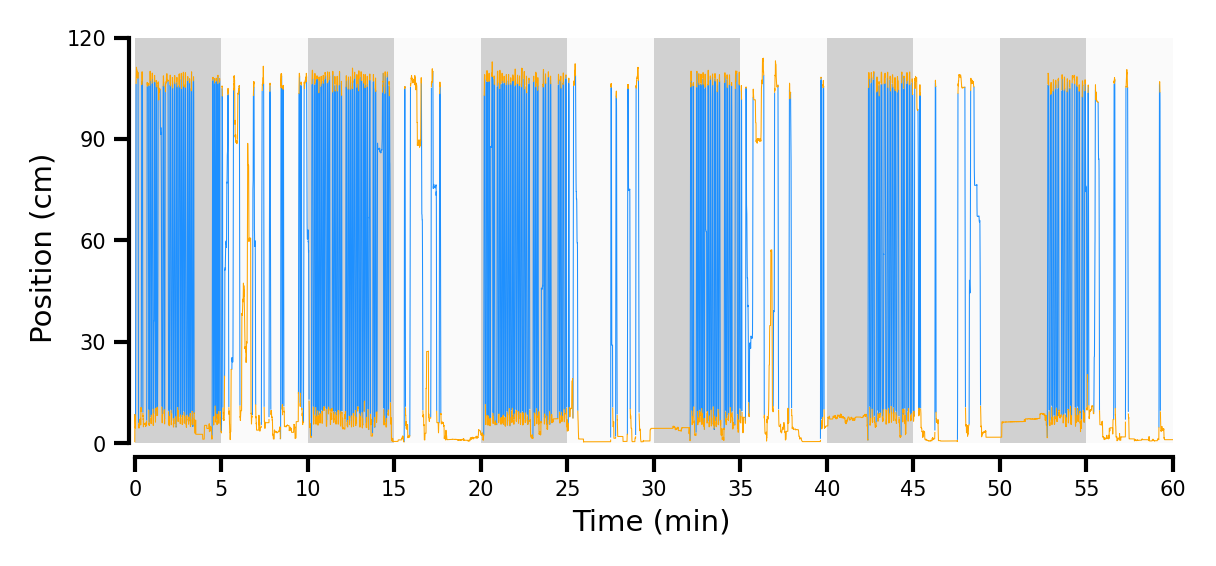

In [28]:

def Figure6B(root, 
            animal='RatF52', session='RatF52_2023_08_02_16_55_51', 
            ax=None):
    '''
    read position file and plot animal trajectory
    '''
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize = (cm2inch(10), cm2inch(4.5)))

    params = get_from_pickle(root, animal, session, name="params.p")
    time = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[3])[:90000]
    pos  = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[4])[:90000]/11
    mask = stitch([get_from_pickle(root, animal, session, name="mask.p")])[0]   
    pos = smooth(pos.astype('float32'), 2)

    running_Xs = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(pos, mask)]]
    idle_Xs = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(pos, mask)]]

    for i in range(0, len(params['blocks'])):
        ax.axvspan(params['blocks'][i][0], params['blocks'][i][1], ymin=1/30, ymax=1,
                    color='grey', alpha=params['rewardProbaBlock'][i]/250, linewidth=0)

    ax.plot(time, running_Xs, color="dodgerblue", lw=.25)
    ax.plot(time, idle_Xs, color="orange", lw=.25)

    ax.set_xlim(0, 3600)
    ax.set_ylim(0, 120)
    ax.set_xticks(np.arange(0, 3601, 300))
    ax.set_xticklabels(np.arange(0, 61, 5))
    ax.set_yticks(np.arange(0, 121, 30))
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Position (cm)")
    space_axes(ax, x_ratio_right=0, x_ratio_left=1/180)

rat_example_lesion = 'RatF52'
session_example_lesion = 'RatF52_2023_08_02_16_55_51' # 2nd afternoon at 120, as in Figure 1B

fig, ax = plt.subplots(1, 1, figsize = (cm2inch(10), cm2inch(4.5)))
Figure6B(root=root, ax=ax, animal=rat_example_lesion, session=session_example_lesion)

# 6C Block-by-block median inter-run durations

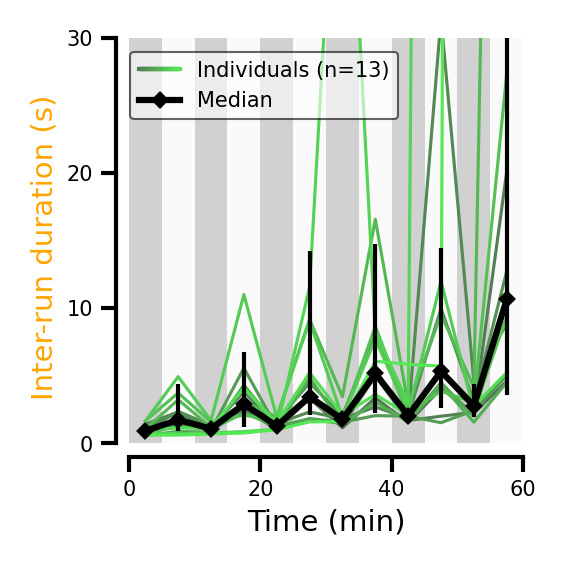

In [29]:
def Figure6C(root, 
             sessionindex=-3, 
             ax=None):
    
    warnings.simplefilter("ignore", category=RuntimeWarning)
    if ax is None:
        ax = plt.gca()
        
    median_all_animals = {}
    tops = {}
    bots = {}
    for idx, animal in enumerate(lesioned_rats):
        session = matchsession(animal, dist120)[sessionindex]
        params = get_from_pickle(root, animal, session, name="params.p")
        blocks = params['blocks']
        rewardProbaBlock = params['rewardProbaBlock']

        example_idleTimeInLeftBin, example_idleTimeInRightBin = get_from_pickle(root, animal, session, name="timeinZone.p")
        data = [example_idleTimeInLeftBin[i]+example_idleTimeInRightBin[i] for i in range(0, 12)]

        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [np.median(data[i]) for i in range(0, len(blocks))],
                linewidth=.75, color=rat_markers[animal][0], 
                zorder=4 if animal == 'RatM00' else 3)

        median_all_animals[animal] = [np.nanmedian(data[i]) for i in range(0, len(blocks))]
        tops[animal] = [np.nanpercentile(data[i], 75) for i in range(0, len(blocks))]
        bots[animal] = [np.nanpercentile(data[i], 25) for i in range(0, len(blocks))]

    median_of_median = [np.nanmedian([median_all_animals[animal][i] for animal in lesioned_rats]) for i in range(len(blocks))]
    tops = [np.nanmedian([tops[animal][i] for animal in lesioned_rats]) for i in range(12)]
    bots = [np.nanmedian([bots[animal][i] for animal in lesioned_rats]) for i in range(12)]

    err = []
    for i in range(12):
        err.append([median_of_median[i] - bots[i], tops[i] - median_of_median[i]])
    err = np.array(err).T

    ax.errorbar([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], median_of_median, yerr=err, 
                    capsize=0, color='k', marker='D', markersize=2, linestyle='-', lw=1.5, elinewidth=1, zorder=5)

    median = ax.plot([-100, -101], [-100, -101], color='k', marker='D', markersize=2, linestyle='-', lw=1.5, label=f'Median', zorder=5)

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
        
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Inter-run duration (s)", color='orange')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 30)
    ax.set_yticks([0, 10, 20, 30])

    add_colored_lesion(ax, handles=[median], labels=['Median'], text=f'Individuals (n={len(lesioned_rats)})')
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize = (cm2inch(4.5), cm2inch(4.5)))
Figure6C(ax=ax, root=root)

# 6D Comparisons of the inter-run duration model parameters in intact and dStr-lesioned rats

$\alpha_0$ 0.3094
$\alpha_t$ 0.0976
$\alpha_u$ 0.6458
$\gamma_0$ 1.0
$\gamma_t$ 0.6811
$\gamma_u$ 0.7659


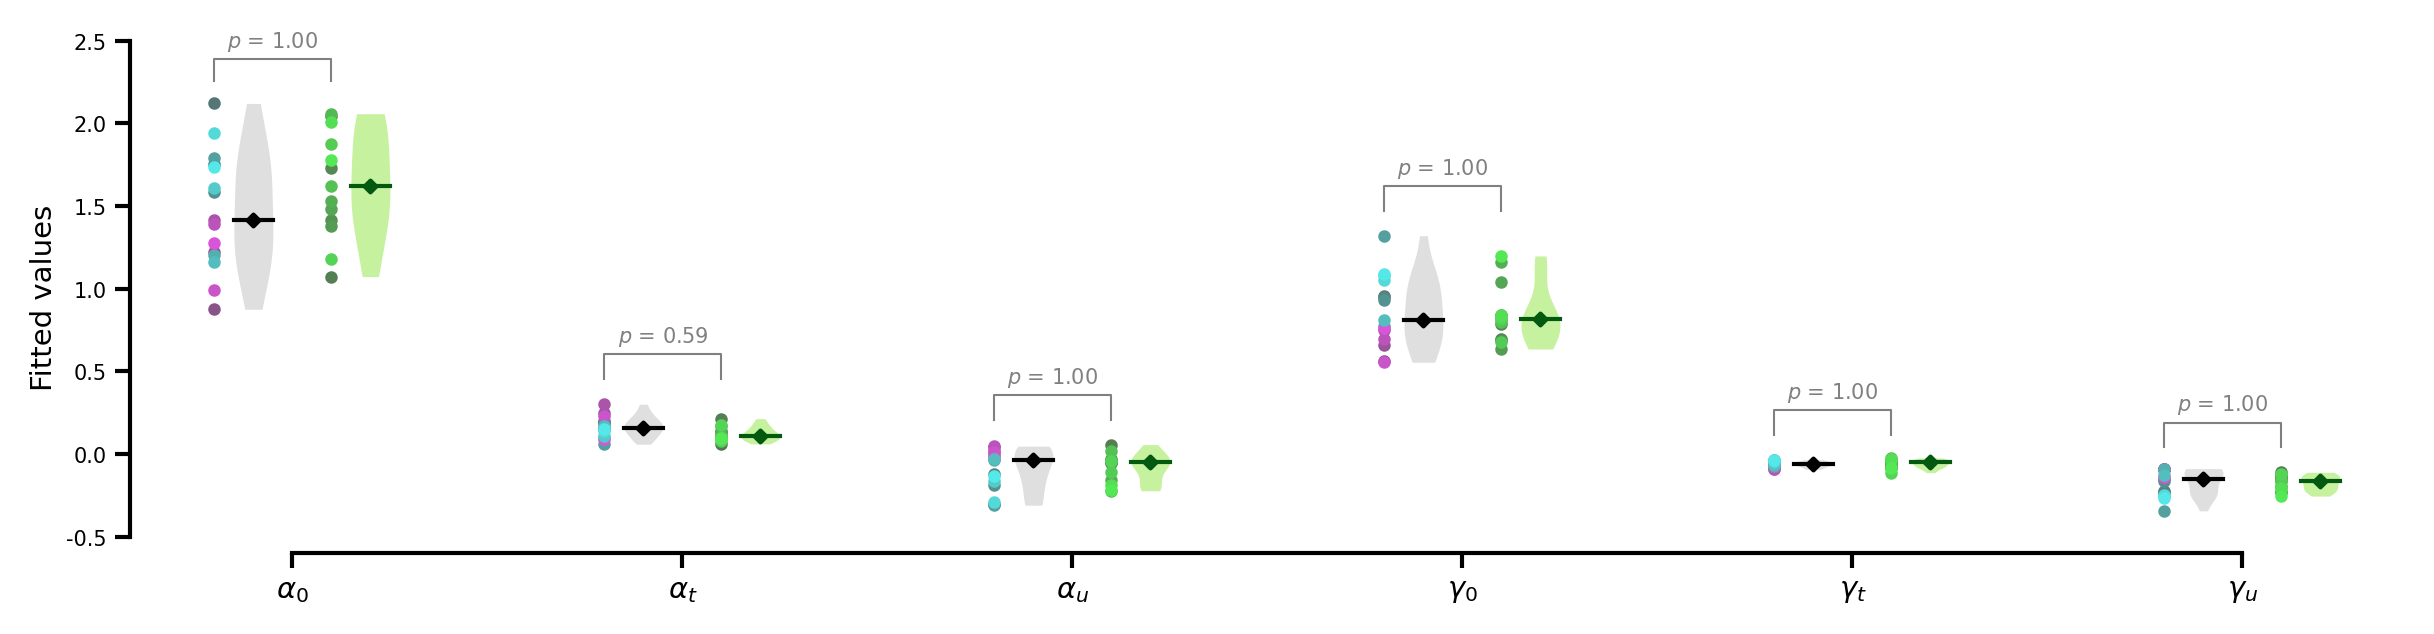

In [30]:
def Figure6D(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    vars = [median_alpha_0, median_alpha_t, median_alpha_u, 
            median_gamma_0, median_gamma_t, median_gamma_u]

    labels = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_u$", 
              r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_u$"]
    
    pvalues = []
    max = []
    for i, (var, label) in enumerate(zip(vars, labels)):
        intact, lesion = [], []
        for animal in intact_rats:
            intact.append(var[animal])
            ax.scatter(i-.2, var[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=5)
        for animal in lesioned_rats:
            lesion.append(var[animal])
            ax.scatter(i+.1, var[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=5)

        # violin intact
        violin_parts = ax.violinplot(positions=[i-.1], dataset=[intact], widths=0.1, showextrema=False)
        for vp in violin_parts['bodies']:
            vp.set_facecolor('silver')
            vp.set_edgecolor('silver')
            vp.set_linewidth(0)
            vp.set_alpha(.5)

        s=.05
        ax.plot([i-.1-s, i-.1+s], [np.median(intact), np.median(intact)], color='k', lw=1, zorder=2)
        ax.scatter(i-.1, np.median(intact), color='k', s=4, zorder=3, marker='D')

        # violin lesion
        violin_parts = ax.violinplot(positions=[i+.2], dataset=[lesion], widths=0.1, showextrema=False)
        for vp in violin_parts['bodies']:
            vp.set_facecolor('xkcd:kiwi green')
            vp.set_edgecolor('xkcd:kiwi green')
            vp.set_linewidth(0)
            vp.set_alpha(.5)
        
        ax.plot([i+.2-s, i+.2+s], [np.median(lesion), np.median(lesion)], color='xkcd:deep green', lw=1, zorder=2)
        ax.scatter(i+.2, np.median(lesion), color='xkcd:deep green', s=4, zorder=3, marker='D')

        perm = exact_mc_perm_test(intact, lesion)
        pvalues.append(perm)
        max.append((np.max(intact), np.max(lesion)))
        print(label, perm)
        
    sig, corrected_pvalues, alphabonf = multipletests_bonferroni(pvalues, )
    for i, perm in enumerate(corrected_pvalues):
        barplot_annotate_brackets(ax, 0, 1, perm, [i-.2, i+.1], [max[i][0], max[i][1]], maxasterix=None)
        
    ax.set_xticks(range(len(vars)))
    ax.set_xticklabels(labels, fontsize=7)
    ax.set_ylim(-.5, 2.5)
    ax.set_yticks([-0.5, 0, 0.5, 1, 1.5, 2, 2.5])
    ax.set_ylabel('Fitted values')
    ax.set_xlim(0, 5)
    space_axes(ax, x_ratio_left=.5/6, x_ratio_right=.5/6)

fig, axs = plt.subplots(1, 1, figsize=(8, 2))
Figure6D(ax=axs);

# 6E Block-by-block median run durations

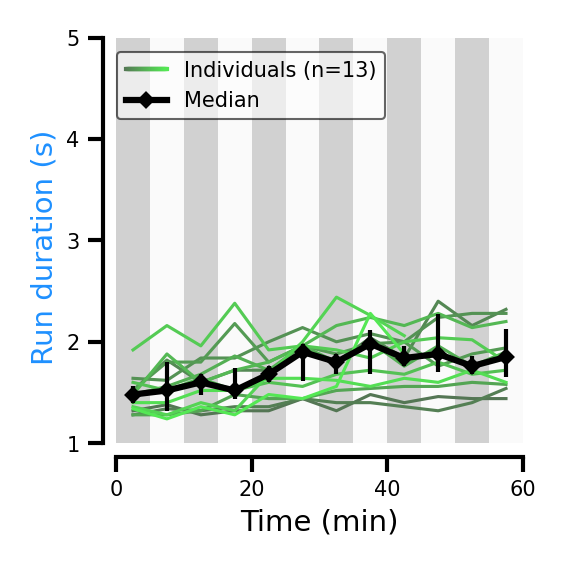

In [31]:
def Figure6E(root, 
             sessionindex=-3, 
             ax=None):
    
    warnings.simplefilter("ignore", category=RuntimeWarning)
    if ax is None:
        ax = plt.gca()

    median_all_animals = {}
    tops = {}
    bots = {}
    for idx, animal in enumerate(lesioned_rats):
        session = matchsession(animal, dist120)[sessionindex]
        params = get_from_pickle(root, animal, session, name="params.p")
        blocks = params['blocks']
        rewardProbaBlock = params['rewardProbaBlock']
        example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")
        data = [example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)]

        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [np.nanmedian(data[i]) if np.nanmedian(data[i]) < 10 else np.nan for i in range(0, len(blocks))],  # RatM52 session block 9 separation is bad because he did not go to the end of the track
                color=rat_markers[animal][0], lw=.75,
                zorder=4 if animal == 'RatM00' else 3)
            
        median_all_animals[animal] = [np.nanmedian(data[i]) for i in range(0, len(blocks))]
        tops[animal] = [np.nanpercentile(data[i], 75) for i in range(0, len(blocks))]
        bots[animal] = [np.nanpercentile(data[i], 25) for i in range(0, len(blocks))]

    median_of_median = [np.nanmedian([median_all_animals[animal][i] for animal in lesioned_rats]) for i in range(len(blocks))]
    tops = [np.nanmedian([tops[animal][i] for animal in lesioned_rats]) for i in range(12)]
    bots = [np.nanmedian([bots[animal][i] for animal in lesioned_rats]) for i in range(12)]

    err = []
    for i in range(12):
        err.append([median_of_median[i] - bots[i], tops[i] - median_of_median[i]])
    err = np.array(err).T

    ax.errorbar([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], median_of_median, yerr=err, 
                    capsize=0, color='k', marker='D', markersize=2, linestyle='-', lw=1.5, elinewidth=1, zorder=5)

    median = ax.plot([-100, -101], [-100, -101], color='k', marker='D', markersize=2, linestyle='-', lw=1.5, label=f'Median', zorder=5)

    
    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)

    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Run duration (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(1, 5)
    ax.set_yticks([1, 2, 3, 4, 5])

    add_colored_lesion(ax, handles=[median], labels=['Median'], text=f'Individuals (n={len(lesioned_rats)})')
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize = (cm2inch(4.5), cm2inch(4.5)))
Figure6E(ax=ax, root=root)

# 6F Comparison of ς

$\varsigma_0$ 0.0085
$\varsigma_t$ 0.1518
$\varsigma_u$ 0.8381


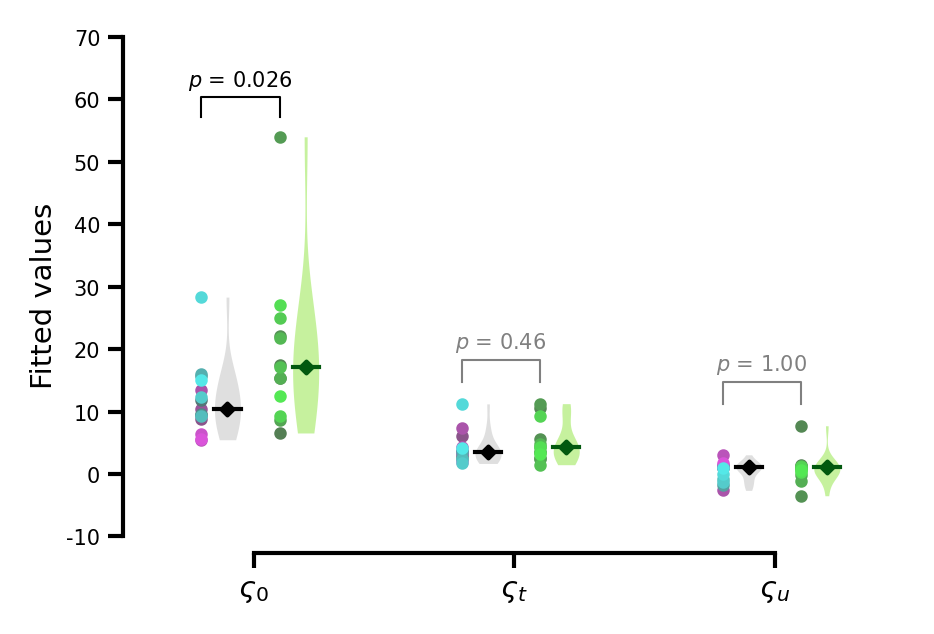

In [32]:
def Figure6F(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    vars = [effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u]

    labels = [r'$\varsigma_0$', r"$\varsigma_t$", r"$\varsigma_u$"]
    
    pvalues = []
    max = []
    for i, (var, label) in enumerate(zip(vars, labels)):
        intact, lesion = [], []
        for animal in intact_rats:
            intact.append(var[animal])
            ax.scatter(i-.2, var[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=5)
        for animal in lesioned_rats:
            lesion.append(var[animal])
            ax.scatter(i+.1, var[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=5)

        # violin intact
        violin_parts = ax.violinplot(positions=[i-.1], dataset=[intact], widths=0.1, showextrema=False)
        for vp in violin_parts['bodies']:
            vp.set_facecolor('silver')
            vp.set_edgecolor('silver')
            vp.set_linewidth(0)
            vp.set_alpha(.5)

        s=.05
        ax.plot([i-.1-s, i-.1+s], [np.median(intact), np.median(intact)], color='k', lw=1, zorder=2)
        ax.scatter(i-.1, np.median(intact), color='k', s=4, zorder=3, marker='D')

        # violin lesion
        violin_parts = ax.violinplot(positions=[i+.2], dataset=[lesion], widths=0.1, showextrema=False)
        for vp in violin_parts['bodies']:
            vp.set_facecolor('xkcd:kiwi green')
            vp.set_edgecolor('xkcd:kiwi green')
            vp.set_linewidth(0)
            vp.set_alpha(.5)
        
        ax.plot([i+.2-s, i+.2+s], [np.median(lesion), np.median(lesion)], color='xkcd:deep green', lw=1, zorder=2)
        ax.scatter(i+.2, np.median(lesion), color='xkcd:deep green', s=4, zorder=3, marker='D')

        perm = exact_mc_perm_test(intact, lesion)
        pvalues.append(perm)
        max.append((np.max(intact), np.max(lesion)))
        print(label, perm)
        
    sig, corrected_pvalues, alphabonf = multipletests_bonferroni(pvalues, )
    for i, perm in enumerate(corrected_pvalues):
        barplot_annotate_brackets(ax, 0, 1, perm, [i-.2, i+.1], [max[i][0], max[i][1]], maxasterix=None)
        
    ax.set_xticks(range(len(vars)))
    ax.set_xticklabels(labels, fontsize=7)
    ax.set_ylim(-10, 70)
    ax.set_yticks([-10, 0, 10, 20, 30, 40, 50, 60, 70])
    ax.set_ylabel('Fitted values')
    ax.set_xlim(0, 2)
    space_axes(ax, x_ratio_left=.5/2, x_ratio_right=.5/2)

fig, axs = plt.subplots(1, 1, figsize=(3, 2))
Figure6F(ax=axs);

# 6G Comparison of β

$\beta$ 0.0057


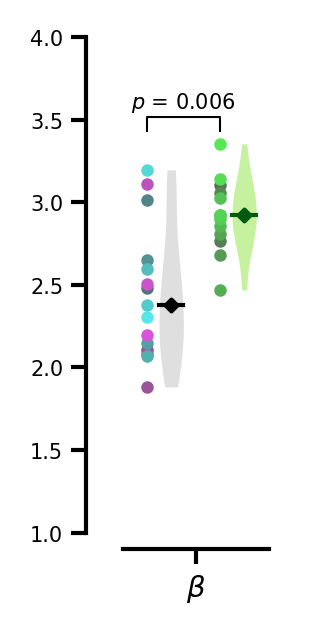

In [33]:
def Figure6G(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    vars = [power]

    labels = [r"$\beta$"]
    
    pvalues = []
    max = []
    for i, (var, label) in enumerate(zip(vars, labels)):
        intact, lesion = [], []
        for animal in intact_rats:
            intact.append(var[animal])
            ax.scatter(i-.2, var[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=5)
        for animal in lesioned_rats:
            lesion.append(var[animal])
            ax.scatter(i+.1, var[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=5)

        
        violin_parts = ax.violinplot(positions=[i-.1], dataset=[intact], widths=0.1, showextrema=False)
        for vp in violin_parts['bodies']:
            vp.set_facecolor('silver')
            vp.set_edgecolor('silver')
            vp.set_linewidth(0)
            vp.set_alpha(.5)

        s=.05
        ax.plot([i-.1-s, i-.1+s], [np.median(intact), np.median(intact)], color='k', lw=1, zorder=2)
        ax.scatter(i-.1, np.median(intact), color='k', s=4, zorder=3, marker='D')


        violin_parts = ax.violinplot(positions=[i+.2], dataset=[lesion], widths=0.1, showextrema=False)
        for vp in violin_parts['bodies']:
            vp.set_facecolor('xkcd:kiwi green')
            vp.set_edgecolor('xkcd:kiwi green')
            vp.set_linewidth(0)
            vp.set_alpha(.5)
        
        ax.plot([i+.2-s, i+.2+s], [np.median(lesion), np.median(lesion)], color='xkcd:deep green', lw=1, zorder=2)
        ax.scatter(i+.2, np.median(lesion), color='xkcd:deep green', s=4, zorder=3, marker='D')

        perm = exact_mc_perm_test(intact, lesion)
        pvalues.append(perm)
        max.append((np.max(intact), np.max(lesion)))
        print(label, perm)
        
    sig, corrected_pvalues, alphabonf = multipletests_bonferroni(pvalues, )
    for i, perm in enumerate(corrected_pvalues):
        barplot_annotate_brackets(ax, 0, 1, perm, [i-.2, i+.1], [max[i][0], max[i][1]], maxasterix=None)
        
    ax.set_xticks(range(len(vars)))
    ax.set_xticklabels(labels, fontsize=7)
    ax.set_ylim(1, 4)
    ax.set_xlim(-.3, .3)
    space_axes(ax, x_ratio_left=.5/2, x_ratio_right=.5/2)

fig, axs = plt.subplots(1, 1, figsize=(1, 2))
Figure6G(ax=axs);

# 6H Comparison of σ

$\sigma_0$ 0.0991
$\sigma_t$ 0.5036
$\sigma_u$ 0.6036


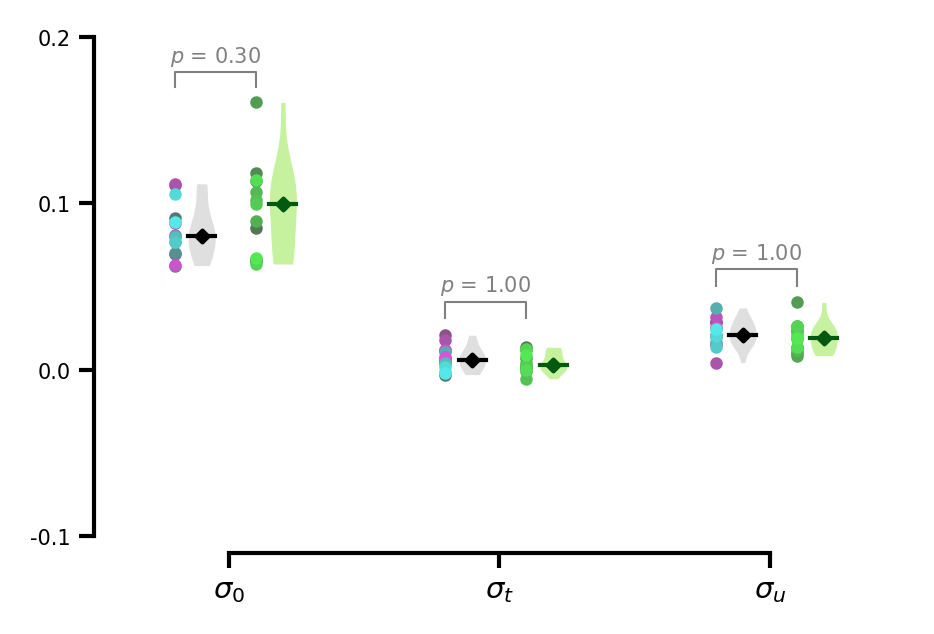

In [34]:
def Figure6H(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    vars = [median_sigma_0, median_sigma_t, median_sigma_u]

    labels = [r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_u$"]
    
    pvalues = []
    max = []
    for i, (var, label) in enumerate(zip(vars, labels)):
        intact, lesion = [], []
        for animal in intact_rats:
            intact.append(var[animal])
            ax.scatter(i-.2, var[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=5)
        for animal in lesioned_rats:
            lesion.append(var[animal])
            ax.scatter(i+.1, var[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=5)

        # violin intact
        violin_parts = ax.violinplot(positions=[i-.1], dataset=[intact], widths=0.1, showextrema=False)
        for vp in violin_parts['bodies']:
            vp.set_facecolor('silver')
            vp.set_edgecolor('silver')
            vp.set_linewidth(0)
            vp.set_alpha(.5)

        s=.05
        ax.plot([i-.1-s, i-.1+s], [np.median(intact), np.median(intact)], color='k', lw=1, zorder=2)
        ax.scatter(i-.1, np.median(intact), color='k', s=4, zorder=3, marker='D')

        # violin lesion
        violin_parts = ax.violinplot(positions=[i+.2], dataset=[lesion], widths=0.1, showextrema=False)
        for vp in violin_parts['bodies']:
            vp.set_facecolor('xkcd:kiwi green')
            vp.set_edgecolor('xkcd:kiwi green')
            vp.set_linewidth(0)
            vp.set_alpha(.5)
        
        ax.plot([i+.2-s, i+.2+s], [np.median(lesion), np.median(lesion)], color='xkcd:deep green', lw=1, zorder=2)
        ax.scatter(i+.2, np.median(lesion), color='xkcd:deep green', s=4, zorder=3, marker='D')

        perm = exact_mc_perm_test(intact, lesion)
        pvalues.append(perm)
        max.append((np.max(intact), np.max(lesion)))
        print(label, perm)
        
    sig, corrected_pvalues, alphabonf = multipletests_bonferroni(pvalues, )
    for i, perm in enumerate(corrected_pvalues):
        barplot_annotate_brackets(ax, 0, 1, perm, [i-.2, i+.1], [max[i][0], max[i][1]], maxasterix=None)
        
    ax.set_xticks(range(len(vars)))
    ax.set_xticklabels(labels, fontsize=7)
    ax.set_ylim(-0.1, .2)
    ax.set_yticks([-0.1, 0, 0.1, 0.2])
    ax.set_xlim(0, 2)
    space_axes(ax, x_ratio_left=.5/2, x_ratio_right=.5/2)

fig, axs = plt.subplots(1, 1, figsize=(3, 2))
Figure6H(ax=axs);

# 6I Fits of run durations across all action cost manipulations

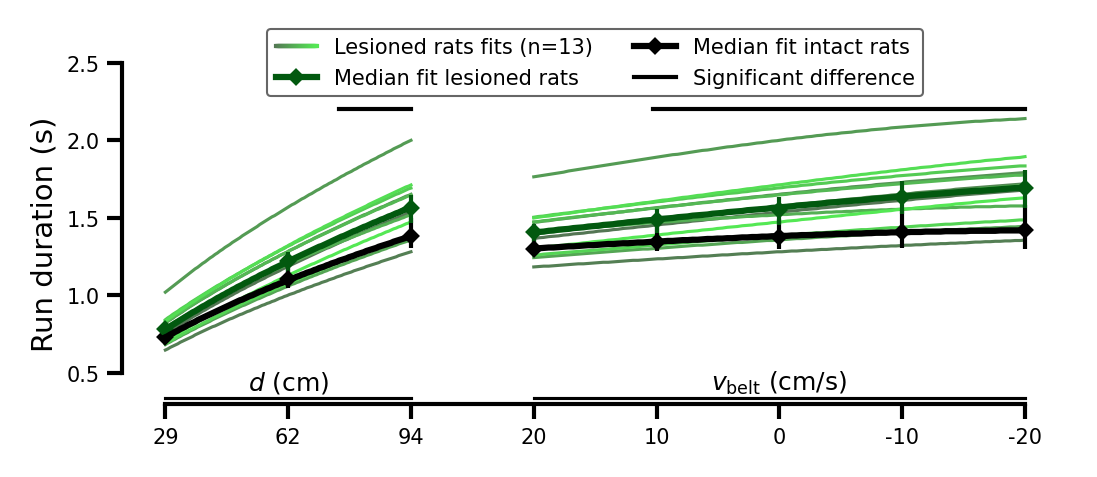

In [35]:
def T_opt_n(D, vbelt, effort_sensitivity, power_effort, power_time):
    '''Dirty Compute the optimal time to cross a distance D with a belt speed vbelt and an effort_sensitivity'''
    T = np.linspace(0.0, 2.5, 1000)
    vmax = (D - vbelt * T) / (T)
    cost = effort_sensitivity * T * vmax ** power_effort + T**power_time
    Topt = T[np.nanargmin(cost)]
    return Topt

median_effort_sensitivity_intact_rat = np.median([effort_sensitivity_0[animal] for animal in intact_rats])
bot_effort_sensitivity_intact_rat = np.percentile([effort_sensitivity_0[animal] for animal in intact_rats], 25)
top_effort_sensitivity_intact_rat = np.percentile([effort_sensitivity_0[animal] for animal in intact_rats], 75)

median_effort_sensitivity_lesion_rat = np.median([effort_sensitivity_0[animal] for animal in lesioned_rats])
bot_effort_sensitivity_lesion_rat = np.percentile([effort_sensitivity_0[animal] for animal in lesioned_rats], 25)
top_effort_sensitivity_lesion_rat = np.percentile([effort_sensitivity_0[animal] for animal in lesioned_rats], 75)

median_power_intact_rat = np.median([power[animal] for animal in intact_rats])
bot_power_intact_rat = np.percentile([power[animal] for animal in intact_rats], 25)
top_power_intact_rat = np.percentile([power[animal] for animal in intact_rats], 75)

median_power_lesion_rat = np.median([power[animal] for animal in lesioned_rats])
bot_power_lesion_rat = np.percentile([power[animal] for animal in lesioned_rats], 25)
top_power_lesion_rat = np.percentile([power[animal] for animal in lesioned_rats], 75)


def Figure6I(ax=None, D_cst=.94, Vbelt_cst=0, EFFORT_SENSITIVITY=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    D = np.linspace(.29, .94, 100)
    xx = np.linspace(0, 2, 100)
    for animal in lesioned_rats: 
        ax.plot(xx, [T_opt_n(d, Vbelt_cst, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for d in D], lw=0.75, c=rat_markers[animal][0], ls='-')

    # plot median intact rat
    ax.plot(xx, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_intact_rat, power_effort=median_power_intact_rat, power_time=3) for d in D], c='k', lw=1.5, zorder=10)
    y = np.asarray([T_opt_n(d, Vbelt_cst, median_effort_sensitivity_intact_rat, power_effort=median_power_intact_rat, power_time=3) for d in [.29, .62, .94]])
    yerr = np.array([y - [T_opt_n(d, Vbelt_cst, bot_effort_sensitivity_intact_rat, power_effort=bot_power_intact_rat, power_time=3) for d in [.29, .62, .94]],
                    [T_opt_n(d, Vbelt_cst, top_effort_sensitivity_intact_rat, power_effort=top_power_intact_rat, power_time=3) for d in [.29, .62, .94]] - y])
    ax.errorbar([0, 1, 2], y, yerr=yerr, capsize=0, color='k', marker='D', markersize=2, linestyle='-', lw=0, elinewidth=1, zorder=5)
    median_intact = ax.plot([-100, -101], [-100, -101], color='k', marker='D', markersize=2, linestyle='-', lw=1.5, label=f'Median fit intact rats', zorder=5)

    # plot median lesion rat
    ax.plot(xx, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_lesion_rat, power_effort=median_power_lesion_rat, power_time=3) for d in D], c='xkcd:deep green', lw=1.5, zorder=10)
    y = np.asarray([T_opt_n(d, Vbelt_cst, median_effort_sensitivity_lesion_rat, power_effort=median_power_lesion_rat, power_time=3) for d in [.29, .62, .94]])
    yerr = np.array([y - [T_opt_n(d, Vbelt_cst, bot_effort_sensitivity_lesion_rat, power_effort=bot_power_lesion_rat, power_time=3) for d in [.29, .62, .94]],
                    [T_opt_n(d, Vbelt_cst, top_effort_sensitivity_lesion_rat, power_effort=top_power_lesion_rat, power_time=3) for d in [.29, .62, .94]] - y])
    ax.errorbar([0, 1, 2], y, yerr=yerr, capsize=0, color='xkcd:deep green', marker='D', markersize=2, linestyle='-', lw=0, elinewidth=1, zorder=5)
    median_lesion = ax.plot([-100, -101], [-100, -101], color='xkcd:deep green', marker='D', markersize=2, linestyle='-', lw=1.5, label=f'Median fit lesioned rats', zorder=5)

    ##########################################################
    VBELT = np.linspace(.2, -.2, 100)
    xxx = np.linspace(3, 7, 100)
    for animal in lesioned_rats:
        ax.plot(xxx, [T_opt_n(D_cst, vbelt, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for vbelt in VBELT], c=rat_markers[animal][0], ls='-', lw=0.75)
    
    # plot median intact rat
    ax.plot(xxx, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_intact_rat, power_effort=median_power_intact_rat, power_time=3) for vbelt in VBELT], c='k', lw=1.5, zorder=10)
    y = np.asarray([T_opt_n(D_cst, vbelt, median_effort_sensitivity_intact_rat, power_effort=median_power_intact_rat, power_time=3) for vbelt in [.2, .1, .02, -.1, -.2]])
    yerr = np.array([y - [T_opt_n(D_cst, vbelt, bot_effort_sensitivity_intact_rat, power_effort=bot_power_intact_rat, power_time=3) for vbelt in [.2, .1, .02, -.1, -.2]],
                    [T_opt_n(D_cst, vbelt, top_effort_sensitivity_intact_rat, power_effort=top_power_intact_rat, power_time=3) for vbelt in [.2, .1, .02, -.1, -.2]] - y])
    ax.errorbar([3, 4, 5, 6, 7], y, yerr=yerr, capsize=0, color='k', marker='D', markersize=2, linestyle='-', lw=0, elinewidth=1, zorder=5)
    median_intact = ax.plot([-100, -101], [-100, -101], color='k', marker='D', markersize=2, linestyle='-', lw=1.5, label=f'Median fit intact rats', zorder=5)

    # plot median lesion rat
    ax.plot(xxx, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_lesion_rat, power_effort=median_power_lesion_rat, power_time=3) for vbelt in VBELT], c='xkcd:deep green', lw=1.5, zorder=10)
    y = np.asarray([T_opt_n(D_cst, vbelt, median_effort_sensitivity_lesion_rat, power_effort=median_power_lesion_rat, power_time=3) for vbelt in [.2, .1, .02, -.1, -.2]])
    yerr = np.array([y - [T_opt_n(D_cst, vbelt, bot_effort_sensitivity_lesion_rat, power_effort=bot_power_lesion_rat, power_time=3) for vbelt in [.2, .1, .02, -.1, -.2]],
                    [T_opt_n(D_cst, vbelt, top_effort_sensitivity_lesion_rat, power_effort=top_power_lesion_rat, power_time=3) for vbelt in [.2, .1, .02, -.1, -.2]] - y])
    ax.errorbar([3, 4, 5, 6, 7], y, yerr=yerr, capsize=0, color='xkcd:deep green', marker='D', markersize=2, linestyle='-', lw=0, elinewidth=1, zorder=5)
    median_lesion = ax.plot([-100, -101], [-100, -101], color='xkcd:deep green', marker='D', markersize=2, linestyle='-', lw=1.5, label=f'Median fit lesioned rats', zorder=5)


    #######################################
    D = [.31, .63, .96]
    VBELT = [.2, .1, 0, -.1, -.2]
    Vbelt_cst = 0
    D_cst = .94
    group1_data = []
    group2_data = []
    for animal in intact_rats:
        group1_data.append([T_opt_n(d, Vbelt_cst, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for d in D]+[T_opt_n(D_cst, vbelt, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for vbelt in VBELT])
    for animal in lesioned_rats:
        group2_data.append([T_opt_n(d, Vbelt_cst, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for d in D]+[T_opt_n(D_cst, vbelt, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for vbelt in VBELT])

    ngroup1 = len(group1_data)
    num_permutations = 10000

    observed_diff = np.median(group1_data, axis=0) - np.median(group2_data, axis=0)
    permuted_diffs = np.zeros((num_permutations, 8))

    np.random.seed(0)
    for i in range(num_permutations):
        combined_data = np.concatenate([group1_data, group2_data], axis=0)
        np.random.shuffle(combined_data)

        permuted_diff = np.median(combined_data[:ngroup1], axis=0) - np.median(combined_data[ngroup1:], axis=0)
        permuted_diffs[i] = permuted_diff

    alpha = 100 
    highGlobCI = 2.5
    lowGlobCI = 2.5
    while alpha >= 5:
        highBand = np.percentile(a=permuted_diffs, q=100-highGlobCI)
        lowBand = np.percentile(a=permuted_diffs, q=lowGlobCI)

        breaksPositive = np.sum([np.sum(permuted_diffs[i, :] > highBand) > 1 for i in range(len(permuted_diffs))])
        breaksNegative = np.sum([np.sum(permuted_diffs[i, :] < lowBand) > 1 for i in range(len(permuted_diffs))])
        
        alpha = ((breaksPositive + breaksNegative) / len(permuted_diffs)) * 100
        highGlobCI = 0.95 * highGlobCI
        lowGlobCI = 0.95 * lowGlobCI
    
    for x, y in zip([[0, 1, 2], [3, 4, 5, 6, 7]], [observed_diff[0:3], observed_diff[3:8]]):
        f = interp1d(x, y, kind='linear')
        xnew = np.linspace(x[0], x[-1], num=100, endpoint=True)
        ynew = f(xnew)
        #only plot y above highband
        y_filtered = ynew[ynew > highBand]
        x_filtered = xnew[ynew > highBand]
        sigline = ax.plot(x_filtered, y_filtered*0+2.2, color='k', zorder=10, label='Significant difference')
        # plot below lowband
        y_filtered = ynew[ynew < lowBand]
        x_filtered = xnew[ynew < lowBand]
        ax.plot(x_filtered, y_filtered*0+2.2, color='k', zorder=10)


    add_colored_lesion(ax=ax, loc='center', bbox=(.5, 1), ncol=2,
                        handles=[median_lesion, median_intact, sigline],
                        labels=['Median fit lesioned rats', 'Median fit intact rats', 'Significant difference'], 
                        text=f'Lesioned rats fits (n={len(lesioned_rats)})')

    ax.set_ylabel('Run duration (s)')
    ax.set_xlim(0, 7)
    ax.set_ylim(0.5, 2.5)
    ax.set_yticks([.5, 1, 1.5, 2, 2.5])
    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(["29", "62", "94", "20", "10", "0", "-10", "-20"]) #±2
    space_axes(ax, y_ratio=.1, x_ratio_left=.05, x_ratio_right=.05)
    annotation_d_vbelt(ax=ax, miny=0.5)
    
fig, axs = plt.subplots(1, 1, figsize=(cm2inch(9), cm2inch(15/4)))
Figure6I(ax=axs)

# 6J Comparison of μ0 for the least and most costly conditions

mu_0 0.0393
mu_0 0.003


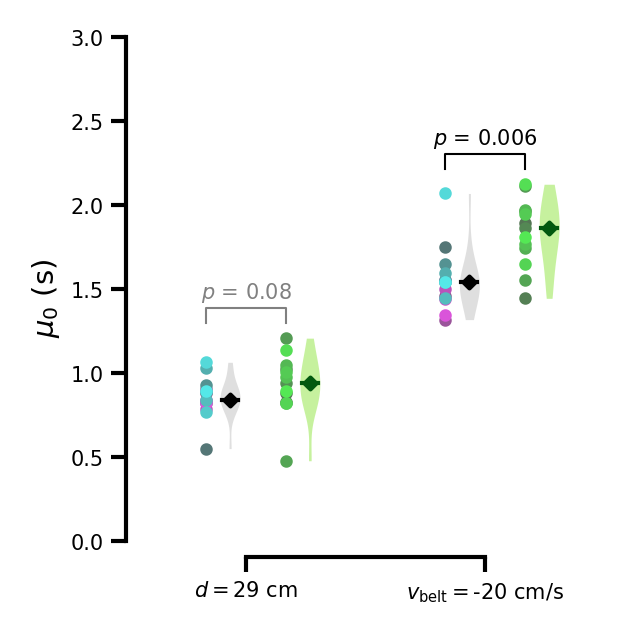

In [36]:
def Figure6J(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in intact_rats:
        intact.append(mu_0[animal]['60'])
        ax.scatter(0, mu_0[animal]['60'], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=5)

    for animal in lesioned_rats:
        lesion.append(mu_0[animal]['60'])
        ax.scatter(1, mu_0[animal]['60'], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=5)



    # violin intact
    violin_parts = ax.violinplot(positions=[0.3], dataset=[intact], widths=0.25, showextrema=False)
    for vp in violin_parts['bodies']:
        vp.set_facecolor('silver')
        vp.set_edgecolor('silver')
        vp.set_linewidth(0)
        vp.set_alpha(0.5)

    s=.1
    ax.plot([0.3-s, 0.3+s], [np.median(intact), np.median(intact)], color='k', lw=1, zorder=2)
    ax.scatter(0.3, np.median(intact), color='k', s=4, zorder=3, marker='D')
    
    # violin lesion
    violin_parts = ax.violinplot(positions=[1.3], dataset=[lesion], widths=0.25, showextrema=False)
    for vp in violin_parts['bodies']:
        vp.set_facecolor('xkcd:kiwi green')
        vp.set_edgecolor('xkcd:kiwi green')
        vp.set_linewidth(0)
        vp.set_alpha(0.5)
        
    ax.plot([1.3-s, 1.3+s], [np.median(lesion), np.median(lesion)], color='xkcd:deep green', lw=1, zorder=2)
    ax.scatter(1.3, np.median(lesion), color='xkcd:deep green', s=4, zorder=3, marker='D')

    _intact = intact.copy()
    _lesion = lesion.copy()
    perm60, shuffles60, observed_diff60 = exact_mc_perm_test(_intact, _lesion, return_shuffled=True)
    print("mu_0", perm60)


    ###############################
    # rev20
    intact, lesion = [], []
    for animal in intact_rats:
        intact.append(mu_0[animal]['rev20'])
        ax.scatter(3, mu_0[animal]['rev20'], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=5)

    for animal in lesioned_rats:
        lesion.append(mu_0[animal]['rev20'])
        ax.scatter(4, mu_0[animal]['rev20'], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=5)


    # violin intact
    violin_parts = ax.violinplot(positions=[3.3], dataset=[intact], widths=0.25, showextrema=False)
    for vp in violin_parts['bodies']:
        vp.set_facecolor('silver')
        vp.set_edgecolor('silver')
        vp.set_linewidth(0)
        vp.set_alpha(0.5)

    ax.plot([3.3-s, 3.3+s], [np.median(intact), np.median(intact)], color='k', lw=1, zorder=2)
    ax.scatter(3.3, np.median(intact), color='k', s=4, zorder=3, marker='D')

    # violin lesion
    violin_parts = ax.violinplot(positions=[4.3], dataset=[lesion], widths=0.25, showextrema=False)
    for vp in violin_parts['bodies']:
        vp.set_facecolor('xkcd:kiwi green')
        vp.set_edgecolor('xkcd:kiwi green')
        vp.set_linewidth(0)
        vp.set_alpha(0.5)
        
    ax.plot([4.3-s, 4.3+s], [np.median(lesion), np.median(lesion)], color='xkcd:deep green', lw=1, zorder=2)
    ax.scatter(4.3, np.median(lesion), color='xkcd:deep green', s=4, zorder=3, marker='D')


    perm, shufflesrev20, observed_diffrev20 = exact_mc_perm_test(intact, lesion, return_shuffled=True)
    print("mu_0", perm)

    sig, corrected_pvalues, alphabonf = multipletests_bonferroni([perm60, perm], )
    corrected_60, corrected_rev20 = corrected_pvalues
    barplot_annotate_brackets(ax, 0, 1, corrected_60, [0, 1], [np.max(_intact), np.max(_lesion)], maxasterix=None)
    barplot_annotate_brackets(ax, 0, 1, corrected_rev20, [3, 4], [np.max(intact), np.max(lesion)], maxasterix=None)
    
    ax.set_xlim(0.5, 3.5)
    ax.set_xticks([0.5, 3.5])
    ax.set_xticklabels([r'$d=$29 cm', r'$v_{\mathrm{belt}}=$-20 cm/s'])
    ax.set_ylim(0, 3)
    ax.set_ylabel(r'$\mu_0$ (s)')
    space_axes(ax, x_ratio_left=.5, x_ratio_right=.5)
        
fig, axs = plt.subplots(1, 1, figsize=(2, 2),)
Figure6J(axs)


# 6K Correlation between ς0 and lesion size

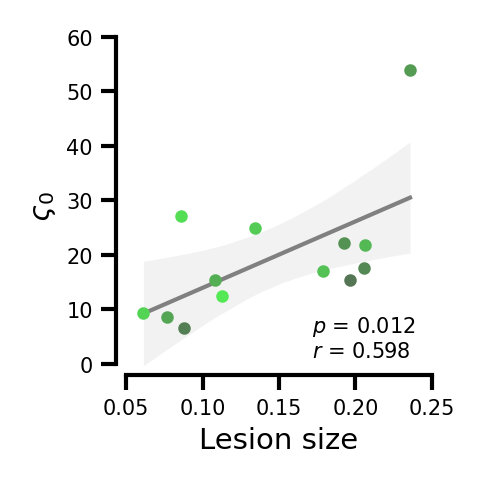

In [37]:
def Figure6K(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    x, y = [], []
    for animal in lesioned_rats:
        ax.scatter(lesion_area[animal], effort_sensitivity_0[animal], color=rat_markers[animal][0], zorder=10, s=4, marker=rat_markers[animal][1])
        x.append(lesion_area[animal])
        y.append(effort_sensitivity_0[animal])

    # fit with np.polyfit
    f = lambda x, *p: np.polyval(p, x)
    p, cov = curve_fit(f, x, y, [1, 1])

    # calculate confidence intervals for fitted line
    xi = np.linspace(np.min(x), np.max(x), 100)
    ps = np.random.multivariate_normal(p, cov, 10000)
    ysample = np.asarray([f(xi, *pi) for pi in ps])
    lower = np.percentile(ysample, 2.5, axis=0)
    upper = np.percentile(ysample, 97.5, axis=0)

    # plot the regression and confidence intervals
    y_fit = np.poly1d(p)(xi)
    ax.plot(xi, y_fit, color='gray', zorder=1)
    ax.fill_between(xi, lower, upper, color='gray', alpha=.1, zorder=0, lw=0)


    # shuffle to get p-value
    observed_slope = p[0]
    num_iterations = 10000
    shuffled_slopes = []

    for _ in range(num_iterations):
        shuffled_y = np.random.permutation(y)
        p_shuffled, _ = curve_fit(f, x, shuffled_y, [1, 1])
        shuffled_slope = p_shuffled[0]
        shuffled_slopes.append(shuffled_slope)

    # Calculate the p-value
    p_value = (np.abs(shuffled_slopes) >= np.abs(observed_slope)).mean()

    # compute r
    y_mean = np.mean(y)
    y_pred = f(x, *p)
    ss_total = np.sum((y - y_mean) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    r_squared = 1 - (ss_res / ss_total)
    r = np.sqrt(r_squared)

    # pvalue annotation
    ax.annotate(f"$p$ = {p_value:.3f}", xy=(.6, .18), xycoords='axes fraction', fontsize=5, ha='left', va='top')
    ax.annotate(f"$r$ = {r:.3f}", xy=(.6, .1), xycoords='axes fraction', fontsize=5, ha='left', va='top')


    ax.set_xlabel('Lesion size')
    ax.set_xlim(0.05, .25)
    ax.set_ylabel(r'$\varsigma_0$')
    ax.set_ylim(0, 60)
    ax.set_yticks([0, 10, 20, 30, 40, 50, 60])
    space_axes(ax)
    
    # print(f"Observed Slope: {observed_slope:.4f}")
    # print(f"P-value: {p_value:.4f}")
    # return shuffled_slopes, observed_slope


fig, axs = plt.subplots(1, 1, figsize=(1.5, 1.5))
Figure6K(ax=axs)
# shuffled_slopes, observed_slope = Figure6K(ax=axs[0])
# plot_shuffling(shuffles=shuffled_slopes, observed=observed_slope, yticks=[-200, -100, 0, 100, 200], ax=axs[1], ylabel='Slope')

# Figure 6: Rats with lesions of the dorsal striatum display increased sensitivity to movement cost. 

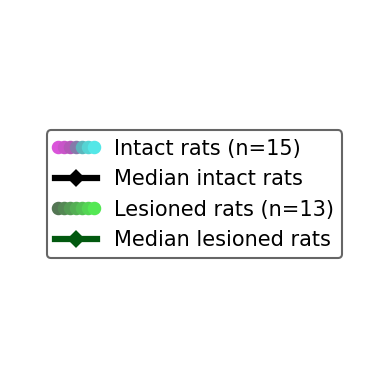

In [38]:
def dummy_legend(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    median_intact = ax.plot([-100, -101], [-100, -101], color='k', marker='D', markersize=2, linestyle='-', lw=1.5, label=f'Median intact rats', zorder=5)
    median_lesion = ax.plot([-100, -101], [-100, -101], color='xkcd:deep green', marker='D', markersize=2, linestyle='-', lw=1.5, label=f'Median lesioned rats', zorder=5)
    
    patches = add_colored_lesion(ax=ax, type='circle', do_return=True)
    add_colored_intact(ax=ax, type='circle', loc='center', bbox=(.5, .5),
                        handles=[median_intact, *patches, median_lesion],
                        labels=['Median intact rats', f'Lesioned rats (n={len(lesioned_rats)})', 'Median lesioned rats'], 
                        text=f'Intact rats (n={len(intact_rats)})')
    ax.axis('off')
    ax.set_xlim(10, 11)
    ax.set_ylim(10, 11)

fig, axs = plt.subplots(1, 1, figsize=(cm2inch(3), cm2inch(3)))
dummy_legend(ax=axs)

$\alpha_0$ 0.3094
$\alpha_t$ 0.0976
$\alpha_u$ 0.6458
$\gamma_0$ 1.0
$\gamma_t$ 0.6811
$\gamma_u$ 0.7659
$\varsigma_0$ 0.0085
$\varsigma_t$ 0.1518
$\varsigma_u$ 0.8381
$\beta$ 0.0057
$\sigma_0$ 0.0991
$\sigma_t$ 0.5036
$\sigma_u$ 0.6036
mu_0 0.0393
mu_0 0.003


/home/thomas/Documents/RunningFastAndSlow/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
/home/thomas/Documents/RunningFastAndSlow/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
/home/thomas/Documents/RunningFastAndSlow/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
/home/thomas/Documents/RunningFastAndSlow/.venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


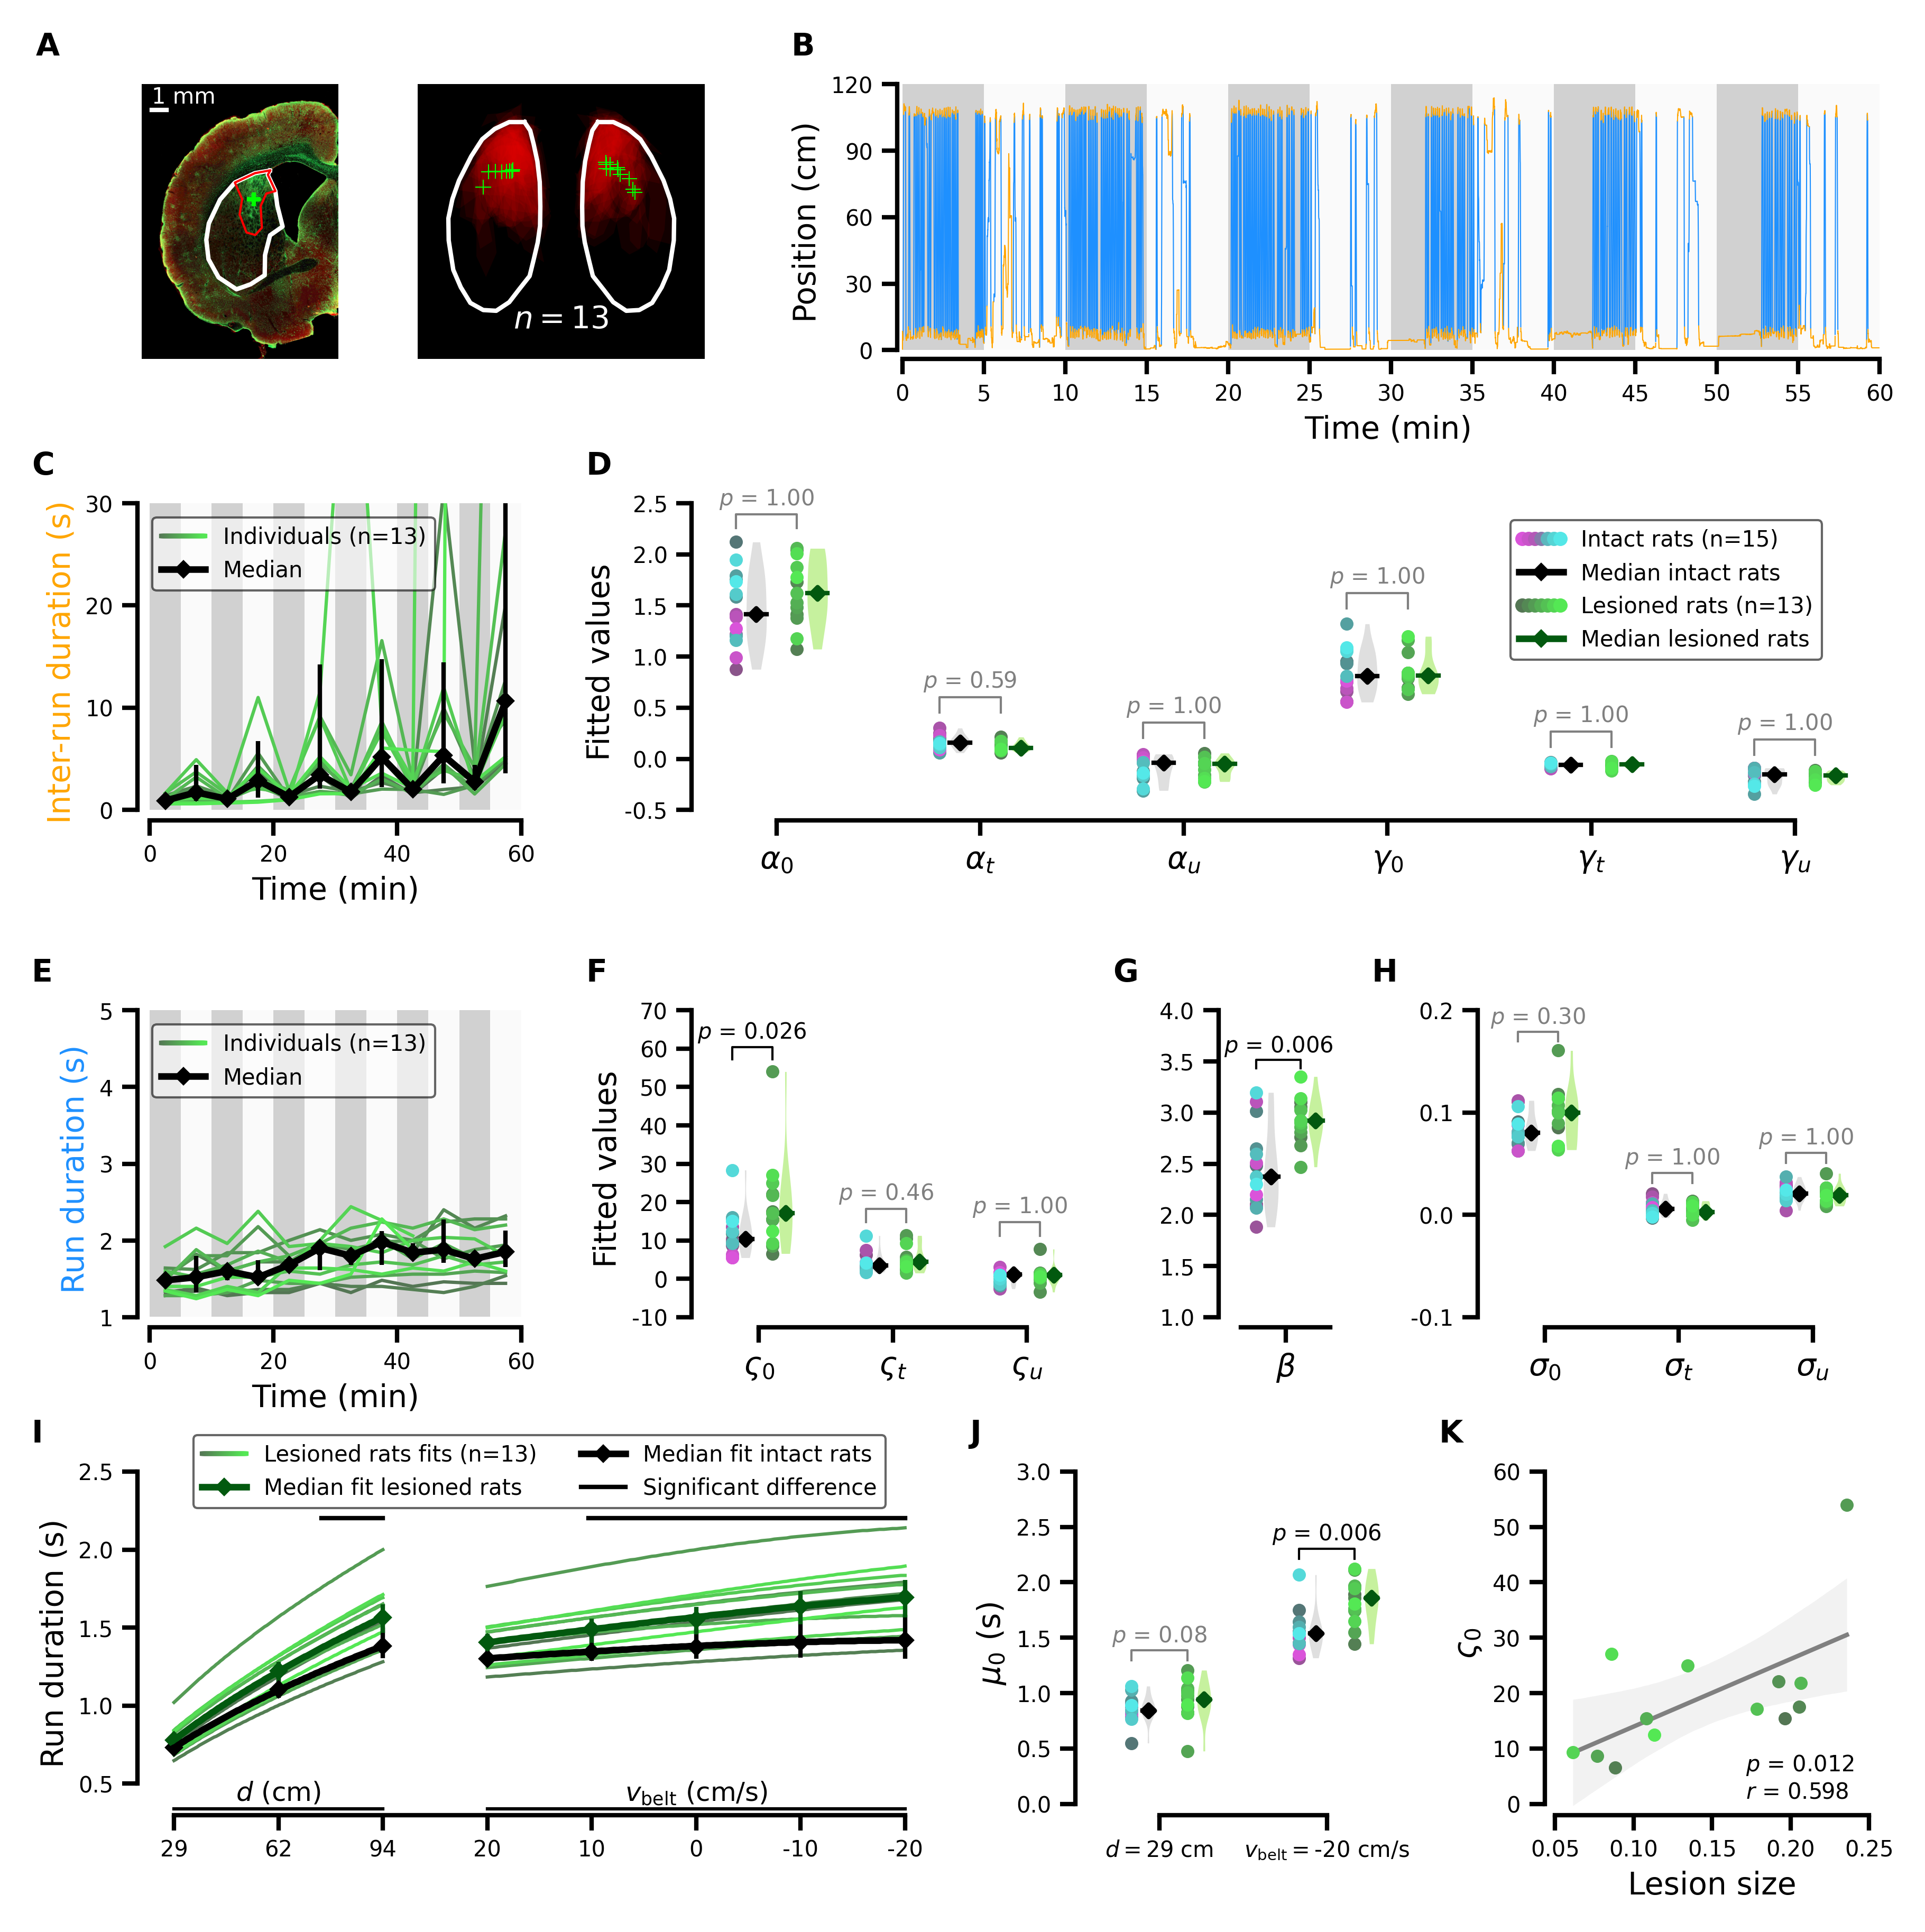

In [40]:
fig=plt.figure(figsize=(cm2inch(18), cm2inch(18)), dpi=600, constrained_layout=True, facecolor='w')

gs0 = fig.add_gridspec(3, 1 , height_ratios=[.8, 2.4, 1], hspace=.3)

row1 = gs0[0].subgridspec(1, 4, width_ratios=[2.5, 3.5, .5, 12])
ax_histology = plt.subplot(row1[0])
ax_lesion = plt.subplot(row1[1])
ax_track = plt.subplot(row1[3])

middle = gs0[1].subgridspec(1, 2, width_ratios=[1, 3])
left = middle[0].subgridspec(2, 1, hspace=.6)
ax_idle = plt.subplot(left[0])
ax_crossing = plt.subplot(left[1])

right = middle[1].subgridspec(2, 1, hspace=.6)
idle_time_ax = plt.subplot(right[0])

bot_right = right[1].subgridspec(1, 3, width_ratios=[1.5, .5, 1.5], wspace=.4)
crossing_time_ax = plt.subplot(bot_right[0])
power_ax = plt.subplot(bot_right[1])
sigma_ax = plt.subplot(bot_right[2])

row4 = gs0[2].subgridspec(1, 4, width_ratios=[1, 1, 1, 1], wspace=.4)
ax_indiv_D = plt.subplot(row4[0:2])
ax_lesioneffect = plt.subplot(row4[2])
ax_corr = plt.subplot(row4[3])


Figure_6A(ax=ax_histology)
Figure_6Abis(ax=ax_lesion)
Figure6B(root=root, ax=ax_track)

Figure6C(root=root, ax=ax_idle)
Figure6D(ax=idle_time_ax)

Figure6E(root=root, ax=ax_crossing)
Figure6F(ax=crossing_time_ax)
Figure6G(ax=power_ax)
Figure6H(ax=sigma_ax)

Figure6I(ax=ax_indiv_D)
Figure6J(ax=ax_lesioneffect)
Figure6K(ax=ax_corr)


for ax, letter in zip([ax_histology, ax_track, ax_idle, idle_time_ax, 
                       ax_crossing, crossing_time_ax, power_ax, sigma_ax, 
                       ax_indiv_D, ax_lesioneffect, ax_corr], 
                        ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']):
    letter_on_subplot(ax, letter)

legend = fig.add_axes([.8, .65, .01, .01])
dummy_legend(ax=legend)

plt.savefig("./Figures_paper/Figure_6.pdf", facecolor='w', 
            edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

plt.savefig("./Figures_paper/Figure_6.svg", facecolor='w', 
            edgecolor='none', bbox_inches='tight', format="svg", dpi=600)